<a href="https://colab.research.google.com/github/Kryptera-K/TSLA-PSAR-QQE-Compression-Bollinger-Strategy/blob/main/TSLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "TSLA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("TSLA_clean.csv", index=False)
df

/tmp/ipython-input-2870459617.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...
2025-11-11,439.619995,442.489990,432.359985,439.399994,60533200
2025-11-12,430.600006,442.329987,426.559998,442.149994,58513500
2025-11-13,401.989990,424.500000,396.339996,423.130005,118948000


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
PSAR_MAX_AF = 0.2
PSAR_SHIFT = 1
PSAR_STEP = 0.02
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5

# -------------------------
# Indicator Functions
# -------------------------

def qqe_value2_falling(df, shift=QQE_SHIFT):
    df = calculate_qqe(df)
    return df['QQE_Value2'] < df['QQE_Value2'].shift(shift)


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df


def price_below_psar(df, shift=PSAR_SHIFT):
    df = df.copy()
    df['PSAR'] = calculate_psar(df)
    df['PSAR_shifted'] = df['PSAR'].shift(shift)
    return df['Close'] < df['PSAR_shifted']


def calculate_psar(df, step=PSAR_STEP, max_af=PSAR_MAX_AF):
    """
    Calculate Parabolic SAR for given high, low, close series.
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    psar = close.copy()
    psar[:] = np.nan

    length = len(close)
    if length < 2:
        return psar

    # Initial trend
    uptrend = True
    af = step
    ep = high.iloc[0]
    sar = low.iloc[0]
    psar.iloc[0] = sar

    for i in range(1, length):
        psar.iloc[i] = sar

        if uptrend:
            sar = sar + af * (ep - sar)
            sar = min(sar, low.iloc[i-1], low.iloc[i])
        else:
            sar = sar + af * (ep - sar)
            sar = max(sar, high.iloc[i-1], high.iloc[i])

        # Trend switch check
        if uptrend:
            if close.iloc[i] < sar:
                uptrend = False
                sar = ep
                ep = low.iloc[i]
                af = step
            else:
                if high.iloc[i] > ep:
                    ep = high.iloc[i]
                    af = min(af + step, max_af)
        else:
            if close.iloc[i] > sar:
                uptrend = True
                sar = ep
                ep = high.iloc[i]
                af = step
            else:
                if low.iloc[i] < ep:
                    ep = low.iloc[i]
                    af = min(af + step, max_af)

    return psar


def qqe_cross_below_level(df, level=QQE_LEVEL):
    df = calculate_qqe(df)
    return (df['QQE_Value1'] < level) & (df['QQE_Value1'].shift(1) >= level)


def bb_close_below_upper(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return df['Close'] < df['BB_Upper']


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["QQE_Value2_Falling"] = qqe_value2_falling(df)
df["PSAR_Price_Below_PSAR"] = price_below_psar(df)

# -------------------------
# Exit conditions
# -------------------------

df["QQE_Value1_CrossBelow_Level"] = qqe_cross_below_level(df)
df["BB_Close_Below_Upper"] = bb_close_below_upper(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'QQE_Value2_Falling',
    'PSAR_Price_Below_PSAR',
]
exit_conditions = [
    'QQE_Value1_CrossBelow_Level',
    'BB_Close_Below_Upper',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-1298005598.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')
/tmp/ipython-input-1298005598.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                         2010-06-29 00:00:00
End                           2025-11-17 00:00:00
Period                         3872 days 00:00:00
Start Value                              100000.0
End Value                         68384310.148096
Total Return [%]                     68284.310148
Benchmark Return [%]                  31391.30845
Max Gross Exposure [%]                      100.0
Total Fees Paid                    1573225.772426
Max Drawdown [%]                        78.714695
Max Drawdown Duration           743 days 00:00:00
Total Trades                                   51
Total Closed Trades                            50
Total Open Trades                               1
Open Trade PnL                     1959579.995261
Win Rate [%]                                 60.0
Best Trade [%]                         478.191449
Worst Trade [%]                        -37.568993
Avg Winning Trade [%]                   49.269889
Avg Losing Trade [%]                   -10.182339


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2010-06-29 00:00:00
End                           2025-11-17 00:00:00
Period                         3872 days 00:00:00
Start Value                              100000.0
End Value                         31491308.449907
Total Return [%]                      31391.30845
Benchmark Return [%]                  31391.30845
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        74.967798
Max Drawdown Duration           779 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                    31391308.449907
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1083015013.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1083015013.py:46: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



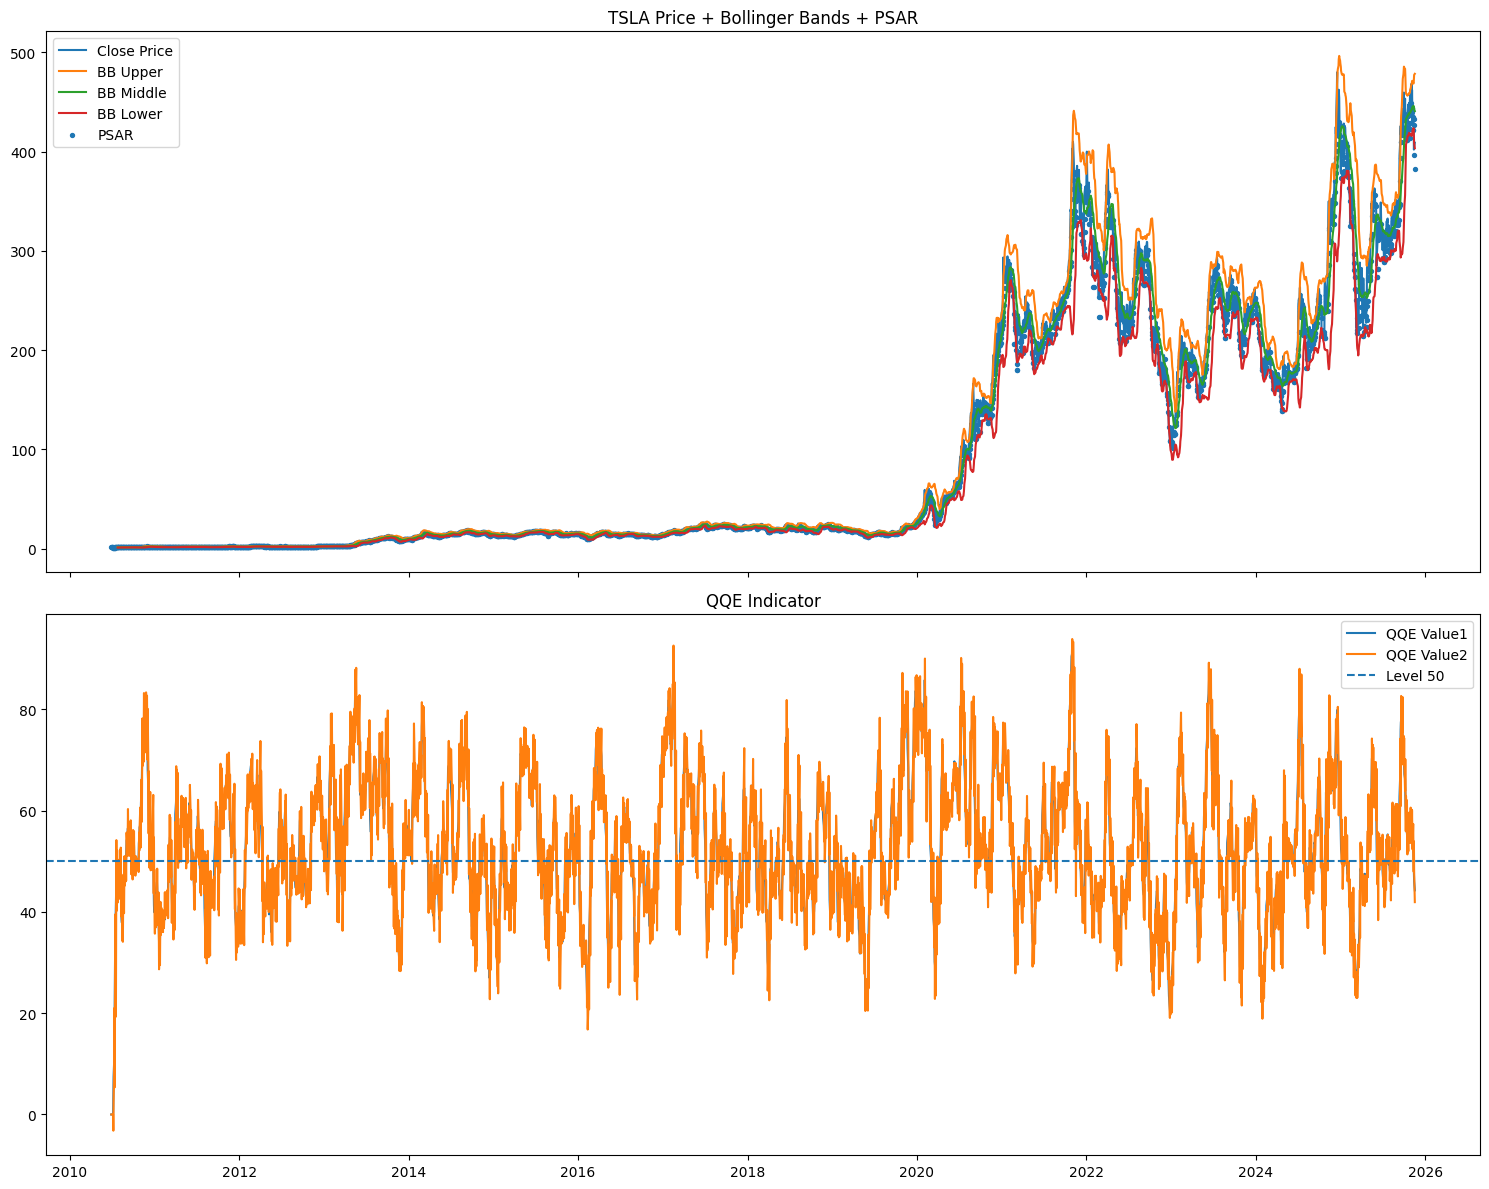

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -----------------------------------
# Download Data
# -----------------------------------
symbol = "TSLA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df = df.dropna()

# -----------------------------------
# Indicator Functions (Your Functions)
# -----------------------------------

BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2

PSAR_MAX_AF = 0.2
PSAR_SHIFT = 1
PSAR_STEP = 0.02

QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5

# --- QQE ---
def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    df = df.copy()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2
    return df

# --- PSAR ---
def calculate_psar(df, step=PSAR_STEP, max_af=PSAR_MAX_AF):
    high = df['High']
    low = df['Low']
    close = df['Close']
    psar = close.copy()
    psar[:] = np.nan

    length = len(close)
    if length < 2:
        return psar

    uptrend = True
    af = step
    ep = high.iloc[0]
    sar = low.iloc[0]
    psar.iloc[0] = sar

    for i in range(1, length):
        psar.iloc[i] = sar

        if uptrend:
            sar = sar + af * (ep - sar)
            sar = min(sar, low.iloc[i-1], low.iloc[i])
        else:
            sar = sar + af * (ep - sar)
            sar = max(sar, high.iloc[i-1], high.iloc[i])

        if uptrend:
            if close.iloc[i] < sar:
                uptrend = False
                sar = ep
                ep = low.iloc[i]
                af = step
            else:
                if high.iloc[i] > ep:
                    ep = high.iloc[i]
                    af = min(af + step, max_af)
        else:
            if close.iloc[i] > sar:
                uptrend = True
                sar = ep
                ep = high.iloc[i]
                af = step
            else:
                if low.iloc[i] < ep:
                    ep = low.iloc[i]
                    af = min(af + step, max_af)

    return psar

# --- Bollinger Bands ---
def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df

# -----------------------------------
# Add Indicators to Data
# -----------------------------------

df = calculate_bollinger_bands(df)
df['PSAR'] = calculate_psar(df)
df = calculate_qqe(df)

# -----------------------------------
# Plotting
# -----------------------------------

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# --- Price + Bollinger Bands + PSAR ---
ax1.plot(df['Close'], label='Close Price')
ax1.plot(df['BB_Upper'], label='BB Upper')
ax1.plot(df['BB_MA'], label='BB Middle')
ax1.plot(df['BB_Lower'], label='BB Lower')
ax1.scatter(df.index, df['PSAR'], label='PSAR', s=8)

ax1.set_title(f"{symbol} Price + Bollinger Bands + PSAR")
ax1.legend()

# --- QQE Value1 & Value2 ---
ax2.plot(df['QQE_Value1'], label='QQE Value1')
ax2.plot(df['QQE_Value2'], label='QQE Value2')
ax2.axhline(50, linestyle="--", label="Level 50")

ax2.set_title("QQE Indicator")
ax2.legend()

plt.tight_layout()
plt.show()
